In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cdsapi

ERA_VERSION = 'ERA5'

In [4]:
# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

In [5]:
# Define the URL for the CDS API
URL = 'https://cads-mini-cci1.copernicus-climate.eu/api'

# Define the dataset and request parameters
dataset = "test-adaptor-arco"
request = {
    "variable": [
        "2m_temperature",  # Variable to retrieve
    ],
    "date": ["1940-01-01/2023-12-31"],  # Date range for the data
    "location": {"longitude": lng, "latitude": lat},  # Location coordinates
    "data_format": "netcdf"  # Format of the retrieved data
}

# Define the filename for the data download
timeseries_file = f"{dataset}.nc"

# Initialize the CDS API client with the URL and API key
client = cdsapi.Client(url=URL, key=KEY)

# Retrieve the data from the CDS API and save it to the specified file
client.retrieve(dataset, request, timeseries_file)

2024-11-27 17:22:28,235 CRITICAL [2024-11-27T00:00:00] System is currently unavailable. Please follow updates [here](https://forum.ecmwf.int/t/cds-ads-and-ewds-down-until-further-notice/8015) and status [here](https://status.ecmwf.int/)
2024-11-27 17:22:28,235 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-27 17:22:28,236 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-27 17:22:28,236 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-27 17:22:28,237

'test-adaptor-arco.nc'

In [6]:
# Make a function to compute the annual mean temperature time series
def warmingStripes(x, y):
    """
    Processes the temperature annual timeseries for the given coordinates.

    This function reads temperature data from a NetCDF file, filters out incomplete years,
    resamples the data to annual means, and converts the temperature from Kelvin to Celsius.

    Parameters:
    x (float): The longitude of the location.
    y (float): The latitude of the location.

    Returns:
    tuple: A tuple containing two elements:
        - years (numpy.ndarray): An array of years corresponding to the annual means.
        - abs_values (numpy.ndarray): An array of annual mean temperatures in Celsius.
    """
    print("Processing warming stripes for coordinates ({}, {})".format(x, y))

    clim_year_stripes_start = 1961
    clim_year_stripes_end = 2010

    norm_stripes_start = 1940
    norm_stripes_end = 1999

    climatology_period_stripes = slice('{:d}-01-01'.format(clim_year_stripes_start), '{:d}-12-31'.format(clim_year_stripes_end))
    normalisation_period_stripes = slice('{:d}-01-01'.format(norm_stripes_start), '{:d}-12-31'.format(norm_stripes_end))  # Not the same as the clim period

    data = xr.open_dataset(timeseries_file)
    data_t2m_pt = data.t2m

    # Remove incomplete year
    current_year = datetime.now().year
    timestamp_string = '{:d}-12-31 00:00:00'.format(current_year - 1)
    cutoff_date = pd.Timestamp(timestamp_string)
    data_t2m_pt_trun = data_t2m_pt.sel(valid_time=slice(None, cutoff_date))

    # Resample the data to annual means
    data_t2m_pt_agg = data_t2m_pt_trun.resample(valid_time="YE").mean()
    years = data_t2m_pt_agg.valid_time.to_index().year.tolist()

    # Calculate the standard deviation for normalization
    data_t2m_pt_agg_std = data_t2m_pt_agg.sel(valid_time=normalisation_period_stripes).std()
    scaling = (data_t2m_pt_agg_std * 3.0)
    
    # Calculate climatology and anomalies
    data_t2m_pt_agg_clim1 = data_t2m_pt_agg.sel(valid_time=climatology_period_stripes).mean()
    data_t2m_pt_agg_anom1 = data_t2m_pt_agg - data_t2m_pt_agg_clim1
    data_t2m_pt_agg_anom_norm1 = data_t2m_pt_agg_anom1 / scaling
    stripes_values = data_t2m_pt_agg_anom_norm1.values

    return (years, stripes_values)

In [7]:
# Call our function
years1, ts1 = warmingStripes(lng, lat)

Processing warming stripes for coordinates (4.35, 50.86)


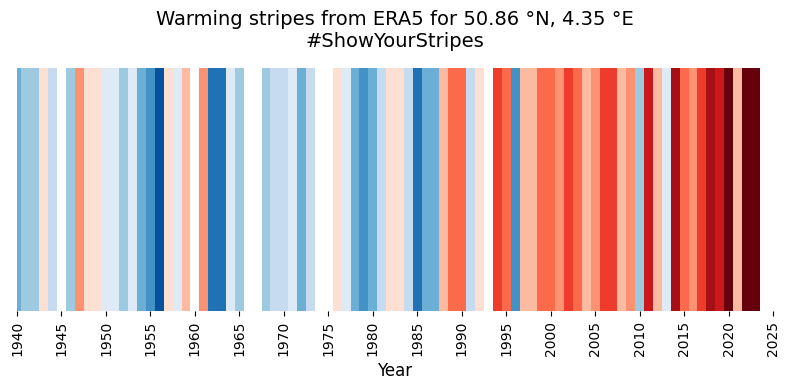

In [13]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

# Custom stripe colors
stripeColorsWhiteCentre = [
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#ffffff',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
]

# Define the range and colormap
vmin, vmax = -1, 1
cmap = ListedColormap(stripeColorsWhiteCentre)
norm = BoundaryNorm(
    boundaries=np.linspace(vmin - 0.01, vmax + 0.01, len(stripeColorsWhiteCentre) + 1),
    ncolors=len(stripeColorsWhiteCentre),
    clip=True
)

# Create a new figure
plt.figure(figsize=(8, 4))

# Map data to colors (clamping values outside [-1, 1])
colors = cmap(norm(np.clip(ts1, vmin, vmax)))

# Plot the data as bars
plt.bar(years1, height=1, width=1.0, color=colors, align='center', edgecolor='none')

# Customize the x-ticks to appear every 5 years
plt.xticks(np.arange(1940, 2026, 5), rotation=90)
plt.xlim(1940, 2025)

# Remove the y-axis ticks and labels for the #ShowYourStripes look
plt.gca().yaxis.set_visible(False)

# Add x-axis label and title
plt.xlabel('Year', fontsize=12)
plt.title(f'Warming stripes from {ERA_VERSION:s} for {abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}\n#ShowYourStripes', fontsize=14)

# Remove spines for a clean look
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()